# <p><center style="font-family:camtasia;font-size:180%;">Rice Classification </center></p>

## **Import**

In [1]:
import os
from tensorflow import keras 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
import warnings
warnings.filterwarnings('ignore')

## **Create a dataframe with the Images and Label**

In [2]:
# Set the path to the dataset
dataset_path = './Rice_Image_Dataset'

# Initialize empty lists for storing the images and labels
images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):
    
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
  # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
       # Load the image and store it in the images list
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        # Store the label for the image in the labels list
        labels.append(subfolder)
 
 # Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

## **Visualization of Dataset**

In [3]:
df.head()

,image,label
0,./Rice_Image_Dataset/Karacadag/Karacadag (1252...,Karacadag
1,./Rice_Image_Dataset/Karacadag/Karacadag (1341...,Karacadag
2,./Rice_Image_Dataset/Karacadag/Karacadag (6484...,Karacadag
3,./Rice_Image_Dataset/Karacadag/Karacadag (9771...,Karacadag
4,./Rice_Image_Dataset/Karacadag/Karacadag (8863...,Karacadag


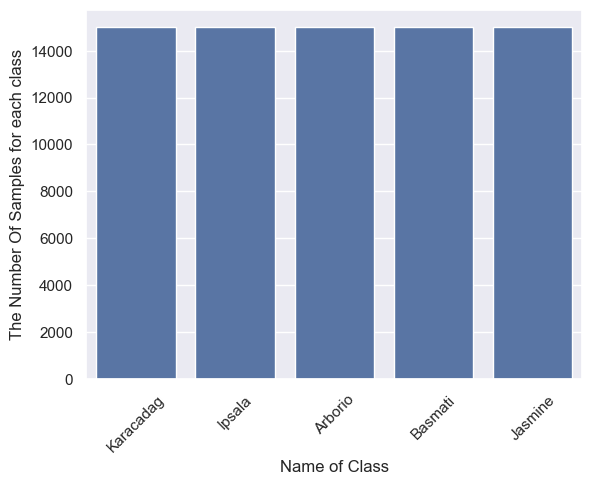

In [4]:
# plot the classes
ax = sns.countplot(x=df.label)

# Set labels and titles
ax.set_xlabel("Name of Class")
ax.set_ylabel("The Number Of Samples for each class")

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

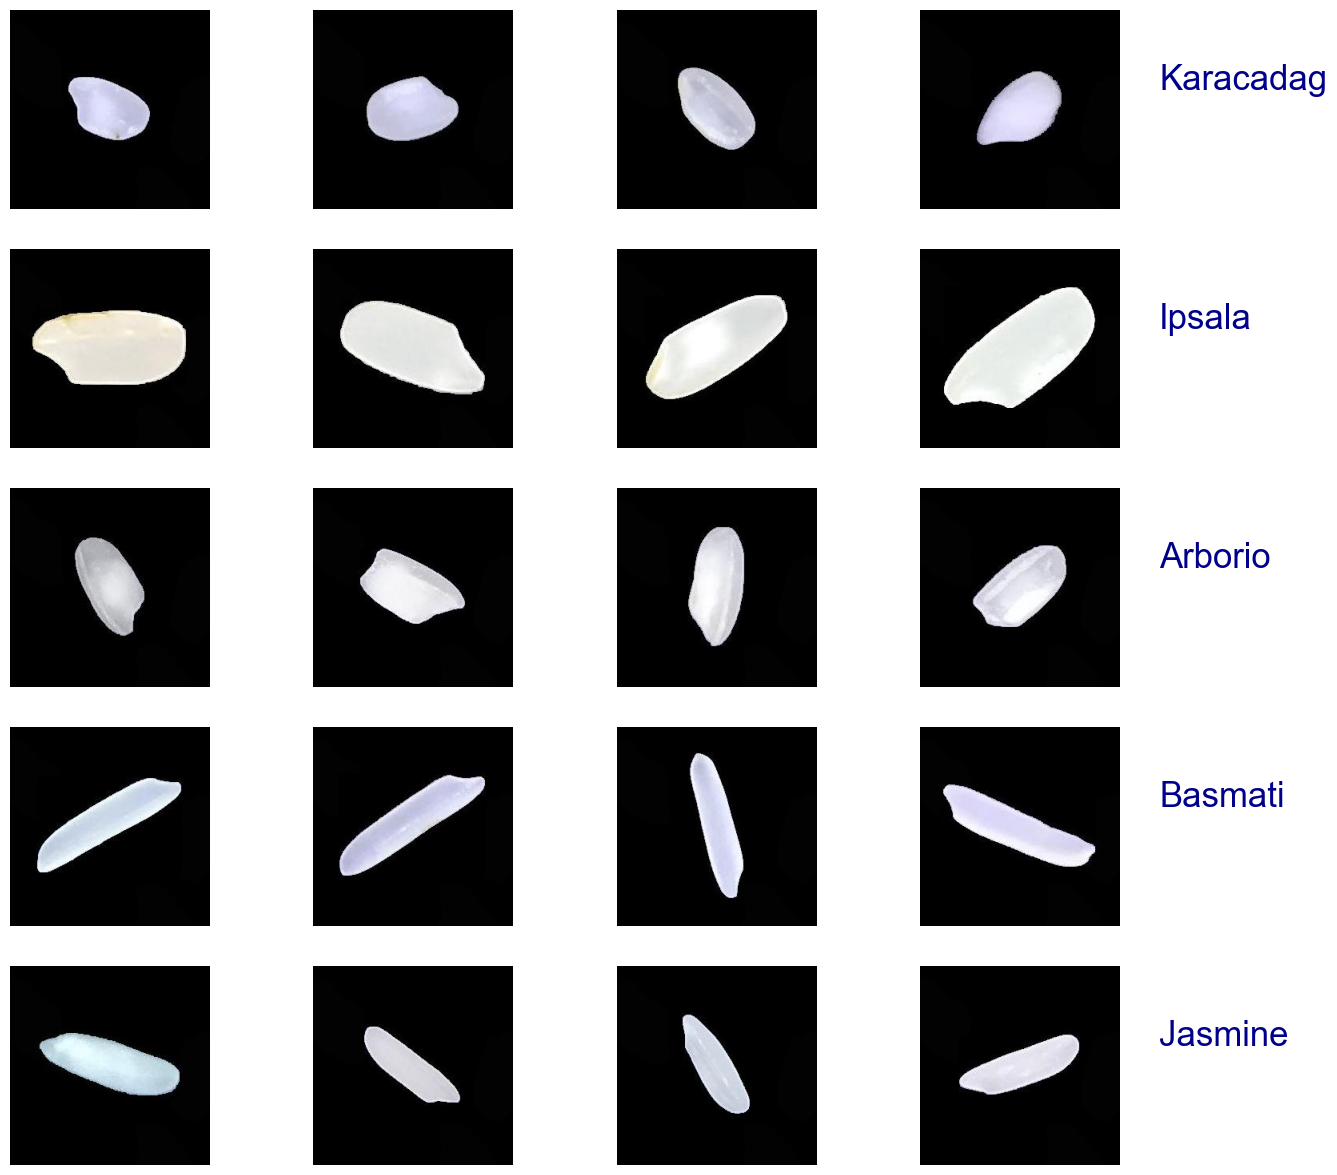

In [5]:
from matplotlib.gridspec import GridSpec
# Create figure and grid of subplots
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 4, figure=fig)

# Loop through each unique category in the DataFrame
for i, category in enumerate(df['label'].unique()):
    # Get the filepaths for the first four images in the category
    filepaths = df[df['label'] == category]['image'].values[:4]
    
    # Loop through the filepaths and add an image to each subplot
    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')
    
    # Add a label to the bottom of the subplot grid
    ax.text(300, 100, category, fontsize=25, color='darkblue')

plt.show()

## **Split Data into Train and Test**

I divided our data into two separate datasets: the training dataset and the testing dataset. The training dataset consists of 80% of the data, while the testing dataset contains the remaining 20%.

To facilitate the training process, I applied the LabelEncoder to labels. This process allowed us to convert the rice types' labels, namely 'Arborio', 'Basmati', 'Ipsala', 'Jasmine', and 'Karacadag', into numerical values. By assigning integer values to the labels, we enabled the utilization of these labels as target variables during the training of our machine learning model.

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42)

# Create a dataframe for the training data
df_train = pd.DataFrame({'image': X_train, 'label': y_train})

# Create a dataframe for the test data
df_test = pd.DataFrame({'image': X_test, 'label': y_test})

# Encode the labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

## **Data AugmentationData Augmentation**

To streamline the preprocessing of our images, we took the following steps. First, we created generators for both the training and testing datasets. These generators allow us to efficiently handle and manipulate the data during the training and testing phases.

Moreover, to enhance the diversity and robustness of our training data, we applied data augmentation techniques specifically to the training dataset. This augmentation process introduces variations in the images by applying transformations such as rotation, scaling, and flipping. By doing so, we expand the dataset and enable our model to learn from a wider range of image variations.

Additionally, we standardized the image dimensions by reshaping them to a uniform size of 50x50 pixels. This resizing ensures that all images in the dataset have consistent dimensions, facilitating the subsequent processing and analysis stages.

In [7]:
from keras.preprocessing.image import ImageDataGenerator
# Set the image size and batch size
image_size = (50, 50)
batch_size = 32

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create a generator for the test data
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 60000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.


## **Modeling**

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# Set the input shape for the model
input_shape = (50, 50, 3)

# Create a Sequential model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [9]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# Train the model on the training data
history = model.fit_generator(train_generator,epochs=25,validation_data=test_generator)

Epoch 1/25
1875/1875 [==============================] - 79s 42ms/step - loss: 0.3390 - accuracy: 0.8668 - val_loss: 0.1700 - val_accuracy: 0.9349
Epoch 2/25
1875/1875 [==============================] - 82s 44ms/step - loss: 0.1534 - accuracy: 0.9427 - val_loss: 0.0921 - val_accuracy: 0.9661
Epoch 3/25
1875/1875 [==============================] - 80s 43ms/step - loss: 0.1152 - accuracy: 0.9580 - val_loss: 0.0956 - val_accuracy: 0.9654
Epoch 4/25
1875/1875 [==============================] - 83s 44ms/step - loss: 0.0974 - accuracy: 0.9647 - val_loss: 0.1214 - val_accuracy: 0.9525
Epoch 5/25
1875/1875 [==============================] - 82s 44ms/step - loss: 0.0822 - accuracy: 0.9708 - val_loss: 0.0696 - val_accuracy: 0.9737
Epoch 6/25
1875/1875 [==============================] - 80s 43ms/step - loss: 0.0732 - accuracy: 0.9742 - val_loss: 0.0869 - val_accuracy: 0.9676
Epoch 7/25
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0644 - accuracy: 0.9779 - val_loss: 0.0414 -

## **Evaluate The Model**

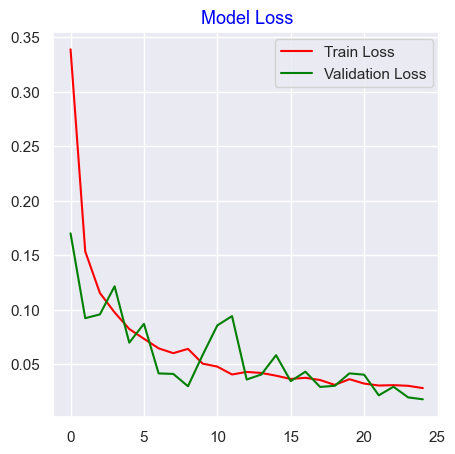

In [18]:
plt.figure(figsize=(5,5))
plt.plot(history.history["loss"],label = "Train Loss", color = "red")
plt.plot(history.history["val_loss"],label = "Validation Loss",color = "green")
plt.title("Model Loss", color = "blue", size = 13)
plt.legend()
plt.show()

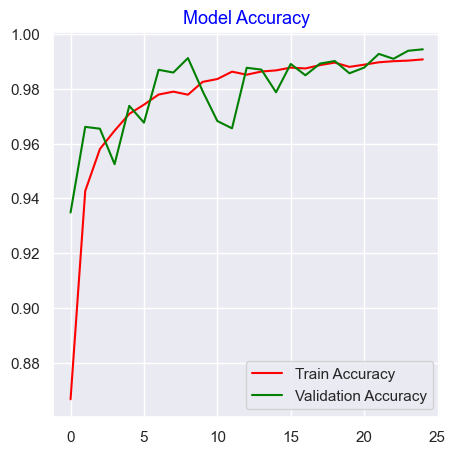

In [20]:
plt.figure(figsize=(5,5))
plt.plot(history.history["accuracy"],label = "Train Accuracy", color = "red")
plt.plot(history.history["val_accuracy"],label = "Validation Accuracy", color = "green")
plt.title("Model Accuracy", color = "blue", size = 13)
plt.legend()
plt.show()

In [13]:
# Evaluate the model on the test data
metrics = model.evaluate(test_generator)
# Print the accuracy of the model
print('Accuracy:', metrics[1])

469/469 [==============================] - 13s 28ms/step - loss: 0.0198 - accuracy: 0.9935
Accuracy: 0.9935333132743835


## **Event tensorBoard**

In [39]:

# Setup TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# add TensorBoard callback to model train
history = model.fit_generator(train_generator,epochs=25,validation_data=test_generator,callbacks=[tensorboard_callback])

Epoch 1/25
1875/1875 [==============================] - 76s 40ms/step - loss: 0.0213 - accuracy: 0.9935 - val_loss: 0.0143 - val_accuracy: 0.9953
Epoch 2/25
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0211 - accuracy: 0.9928 - val_loss: 0.0564 - val_accuracy: 0.9815
Epoch 3/25
1875/1875 [==============================] - 83s 44ms/step - loss: 0.0202 - accuracy: 0.9934 - val_loss: 0.0219 - val_accuracy: 0.9931
Epoch 4/25
1875/1875 [==============================] - 82s 44ms/step - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.0117 - val_accuracy: 0.9961
Epoch 5/25
1875/1875 [==============================] - 80s 43ms/step - loss: 0.0211 - accuracy: 0.9933 - val_loss: 0.0131 - val_accuracy: 0.9955
Epoch 6/25
1875/1875 [==============================] - 80s 43ms/step - loss: 0.0207 - accuracy: 0.9935 - val_loss: 0.0283 - val_accuracy: 0.9914
Epoch 7/25
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0219 - accuracy: 0.9931 - val_loss: 0.0276 -

Reusing TensorBoard on port 6006 (pid 2361), started 1:35:20 ago. (Use '!kill 2361' to kill it.)

In [43]:
# run TensorBoard in Jupyter Notebook
%load_ext tensorboard
%tensorboard --logdir logs/fit


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2361), started 2:50:27 ago. (Use '!kill 2361' to kill it.)

## **Save Model**

In [38]:
model.save('model.h5')
print ("Model saved successfully!")

Model saved successfully!


## **Show layer and Weight**

In [42]:
# Menampilkan ringkasan model
model.summary()

# Mengakses bobot model
model_weights = model.get_weights()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dense (Dense)               (None, 128)               9